In [ ]:
####################
# Volume des pav finalement non pris en compte... à supprimer?
# Rayon de couverture des pav fixé à 150m... pertinent ou pas?
# On pourrait tenir compte de leur volume et de la densité de population mais quels coefficients??
#################### 

In [1]:
import contextily as ctx
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import requests


In [2]:
output_maps_path = '/home/marthe/Documents/DS/bacasable_doc/'

# Préparation des données géographiques de Marseille

In [3]:
# Importation des données géographiques des quartiers de Marseille
url = 'https://www.data.gouv.fr/api/1/datasets/r/8a8f7f54-7f91-482c-a78c-dd09d893d1b6'
file = requests.get(url)
data = file.content
quartiers_data = gpd.read_file(data)
quartiers_data.head(2)

,DEPCO,NOM_CO,NOM_QUA,geometry
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((5.38086 43.29924, 5.38087 43.2..."
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((5.38525 43.29906, 5.38485 43.2..."


In [4]:
quartiers_map = quartiers_data.rename({'NOM_QUA' : 'Quartier'}, axis = 1)
quartiers_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Préparation des données des pav

In [5]:
# Importation des données concernant les points d'apport volontaire
url = 'https://www.data.gouv.fr/api/1/datasets/r/e46c6879-49e7-4727-8f3b-62df90ac5a5a'
gouv_data = pd.read_csv(url, sep = ';')

In [6]:
gouv_data.head(2)

,OBJECTID,Ex identifiant CT,Date création mobilier,Famille Osis,Type de colonne,Modèle,Volume intérieur m3,longitude,latitude,Date de mise à jour de la donnée,...,Code postal,Quartier,Accessibilité,Nom de colonne,Abréviation type de flux,Trigramme de la commune,Propriétaire,created_date,last_edited_date,geo_point_2d
0,125490,PAV07076,2022-12-31T01:00:00+00:00,Equipement Mobilier Urbain,Aérien,COMPOECO,3.0,5.361002,43.280296,2026-01-22T13:58:59+00:00,...,13007.0,BOMPARD,NaN,NaN,NaN,MRS7,Propriétaire Privé,2025-12-22T15:36:07+00:00,2024-02-02T11:13:06+00:00,"43.28029575458368, 5.361001581597926"
1,125491,ENT07035,2022-12-31T01:00:00+00:00,Equipement Mobilier Urbain,Enterré,CITEC T5,3.0,5.366096,43.270026,2026-01-22T11:49:15+00:00,...,13007.0,LE ROUCAS BLANC,NaN,NaN,NaN,MRS7,NaN,2025-12-22T15:36:07+00:00,2024-02-02T11:13:06+00:00,"43.27002588878141, 5.366096461663119"


In [7]:
# Extraction des variables d'intérêt
pav_data = gouv_data[['OBJECTID', 'Code Commune INSEE', 'Quartier', 'Volume intérieur m3', 'longitude', 'latitude']]


In [8]:
# Extraction des observations concernant les quartiers de Marseille
pav_marseille = pav_data.loc[(pav_data['Code Commune INSEE'] > 13200) & (pav_data['Code Commune INSEE'] < 13217)]
pav_marseille = pav_marseille.dropna(axis = 0, subset = ['Quartier'])
pav_marseille.head()


,OBJECTID,Code Commune INSEE,Quartier,Volume intérieur m3,longitude,latitude
0,125490,13207.0,BOMPARD,3.0,5.361002,43.280296
1,125491,13207.0,LE ROUCAS BLANC,3.0,5.366096,43.270026
2,125502,13209.0,STE MARGUERITE,3.0,5.412423,43.273180
3,125504,13209.0,LE CABOT,3.0,5.417667,43.261696
4,125505,13213.0,SAINT JEROME,4.0,5.420109,43.338754


In [10]:
# Uniformisation des noms de quartiers 
# Attention : certains quartiers de la carte ne sont pas référencés dans les données de pav (-> CARPIAGNE)

quartiers_map['Quartier'] = quartiers_map['Quartier'].replace(
    {
        'SAINT MAURON' : 'SAINT MAURONT',
        'VIELLE CHAPELLE' : 'VIEILLE CHAPELLE'
    }
)

pav_marseille['Quartier'] = pav_marseille['Quartier'].replace(
    {
    'CHATEAU GOMBERT' : 'CHATEAU-GOMBERT',
    'LA POINTE ROUGE' : 'POINTE ROUGE',
    'LA VILLETTE' : 'LA VILETTE',
    'LE ROUCAS' : 'ROUCAS BLANC',
    'LE ROUCAS BLANC' : 'ROUCAS BLANC',
    'LES CHUTES LAVIES' : 'CHUTES LAVIE',
    'LES CINQ AVENUES' : 'CINQ AVENUES',
    'LES GRANDS CARMES' : 'GRANDS CARMES',
    'ST BARNANE' : 'SAINT BARNABE',
    'STE MARGUERITE' : 'SAINTE MARGUERITE'
}
)




In [11]:
# conversion en geodataframe
gdf_pav_marseille = gpd.GeoDataFrame(
    pav_marseille,
    geometry=gpd.points_from_xy(
        pav_marseille['longitude'],
        pav_marseille['latitude'],
        crs="EPSG:4326"))

gdf_pav_marseille = gdf_pav_marseille.to_crs(2154)

# Détermination de la zone couverte

In [14]:
zone_couverte = gdf_pav_marseille.copy()
zone_couverte['Volume intérieur m3'] = zone_couverte['Volume intérieur m3'].replace({2000.0 : 2.0, 3000.0 : 3.0})
zone_couverte['Volume intérieur m3'] = zone_couverte['Volume intérieur m3'].fillna(1.0)
zone_couverte['Volume intérieur m3'].unique()

array([3. , 4. , 2. , 1. , 5. , 3.2, 2.2, 1.8])

In [15]:
# Ajout des surfaces couvertes (rayon autour de chaque pav)
rayon = 150
zone_couverte['geometry'] = zone_couverte['geometry'].buffer(rayon)
zone_couverte.head(2)


,OBJECTID,Code Commune INSEE,Quartier,Volume intérieur m3,longitude,latitude,geometry
0,125490,13207.0,BOMPARD,3.0,5.361002,43.280296,"POLYGON ((891879.996 6245213.308, 891879.273 6..."
1,125491,13207.0,ROUCAS BLANC,3.0,5.366096,43.270026,"POLYGON ((892327.817 6244084.537, 892327.095 6..."


In [16]:
# regroupement de l'ensemble des zones de couverture en une seule zone couverte
# pour éviter la superposition de zones couvertes par plusieurs pav sur la carte finale
zone_couverte = zone_couverte.dissolve().reset_index()

In [ ]:
# Changement de système pour permettre les calculs d'aire
quartiers_map = quartiers_map.to_crs(2154)

In [23]:
# séparation de la zone couverte par quartier
couverture = quartiers_map.copy()
couverture['geometry'] = couverture['geometry'].apply(lambda x : x.intersection(zone_couverte['geometry'][0]))

# Calcul du taux de couverture par quartier
couverture['taux_couverture'] = couverture['geometry'].area/quartiers_map['geometry'].area*100
couverture['taux_couverture'] = couverture['taux_couverture'].apply(lambda x : round(x))


In [52]:
quartiers_map = quartiers_map.merge(couverture[['Quartier', 'taux_couverture']], on = 'Quartier')

In [30]:
quartiers_map = quartiers_map.to_crs(3857)
couverture = couverture.to_crs(3857)
gdf_pav_marseille = gdf_pav_marseille.to_crs(3857)

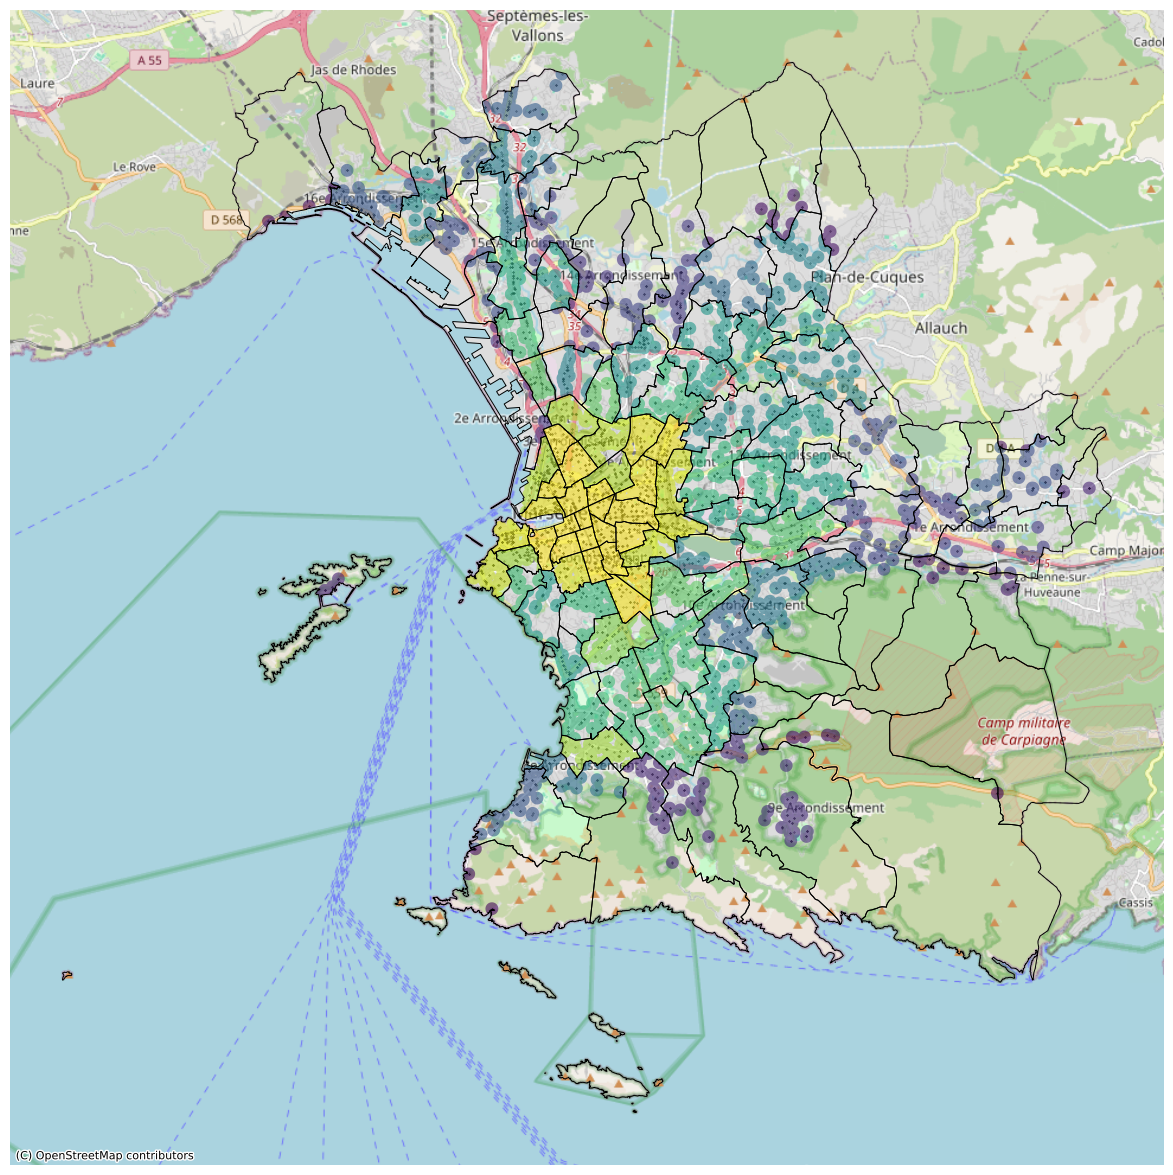

In [31]:
base = quartiers_map.boundary.plot(edgecolor = 'black', linewidth = 0.7, figsize = (15,15))


gdf_pav_marseille.plot(
    ax = base,
    color = 'Black',
    markersize = 0.1
    )

couverture.plot(
    ax = base,
    column = 'taux_couverture',
    alpha = 0.6
    )


ctx.add_basemap(ax = base, source = ctx.providers.OpenStreetMap.Mapnik)

base.set_axis_off()


In [48]:
quartiers_map

,DEPCO,NOM_CO,Quartier,geometry
0,13201,Marseille 1er Arrondissemen,BELSUNCE,"MULTIPOLYGON (((598994.236 5357630.831, 598995..."
1,13201,Marseille 1er Arrondissemen,CHAPITRE,"MULTIPOLYGON (((599483.652 5357603.476, 599438..."
2,13201,Marseille 1er Arrondissemen,NOAILLES,"MULTIPOLYGON (((599076.969 5357093.129, 599095..."
3,13201,Marseille 1er Arrondissemen,OPERA,"MULTIPOLYGON (((598596.988 5356556.38, 598523...."
4,13201,Marseille 1er Arrondissemen,SAINT CHARLES,"MULTIPOLYGON (((598923.007 5357962.82, 598906...."
...,...,...,...,...
106,13215,Marseille 15e Arrondissemen,LA VISTE,"MULTIPOLYGON (((596417.473 5365914.428, 596400..."
107,13216,Marseille 16e Arrondissemen,L'ESTAQUE,"MULTIPOLYGON (((592989.338 5367101.083, 592992..."
108,13216,Marseille 16e Arrondissemen,LES RIAUX,"MULTIPOLYGON (((590952.643 5367706.118, 590970..."
109,13216,Marseille 16e Arrondissemen,SAINT ANDRE,"MULTIPOLYGON (((594442.387 5364428.559, 594436..."


In [63]:
map = folium.Map(
    location = [43.3, 5.4],
    tiles = 'cartodbpositron',
    zoom_start = 12,
    max_zoom=17,
    control_scale=True
    )


gdf_pav_marseille.explore(
    m = map,
    tooltip = ['Volume intérieur m3'],
    marker_kwds=dict(radius=0.5, fill=True),
    color = 'Black'
    )

cmap = 'RdBu'

couverture.explore(
    m = map,
    column = 'taux_couverture',
    cmap = cmap,
    popup = True,
    style_kwds =dict(fillOpacity = 0.8),
    legend = False
    )


quartiers_map.explore(
    m = map,
    column = 'taux_couverture',
    cmap = cmap,
    tooltip = ['Quartier', 'taux_couverture'],
    style_kwds = dict(
        fillOpacity = 0,
        color = 'black',
        opacity = 0.5,
    ),
    highlight_kwds = dict(
        fillOpacity = 0.5
    )
    )


map_title = "couverture des pav (rayon 150 m)"
title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{map_title}</h1>'
map.get_root().html.add_child(folium.Element(title_html))


map.save(output_maps_path + 'couverture_quartier.html')


